In [1]:
#import sys
#import pip
#!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install opencage==1.1.0
#!pip install geocoder
#!pip install descartes
#!pip install geopandas

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [25]:
import pandas as pd
import urllib.request
import requests
import csv
import numpy as np
import random # library for random number generation
from geopy.geocoders import Nominatim
import geocoder as gc
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium # plotting library

# Coffee Shop

## Town Selection

Coffee keeps the world running especially early in the morning. Living in New Jersey often means early mornings with long commutes. We're aiming to provide commuters with easy access to early morning caffeine. To ensure the success of our new venture, we want to find the best town in NJ with a large amount of commuter traffic but lacks a crucial early morning coffee provider.

## Data

We'll use the NJ Transit data to see which cities in Bergen County along the transit lines have the most growth potential.  We'll look at the current population and employment statistics as well as the projectiosn put out by NJ Transit to assess which areas already have high levels of traffic, but also expect to see large amount of growth.   Based on this, we will decide on a town for our flagship location.  

In [23]:
NJ=pd.read_csv("NJ_DATA_1.csv",index_col=None)
NJ.columns = NJ.columns.str.replace(' ', '_')
NJ.rename(columns={'2015_Population':'Pop_2015', '2045_Population':'Pop_2045', 'Annualized_%_Population_Change_2015-2045':'Pop_Change', '2015_Households':'House_2015', '2045_Households':'House_2045', 'Annualized_%_Household_Change_2015-2045':'House_Change', '2015_Employment':'Employ_2015', '2045_Employment':'Employ_2045', 'Annualized_%_Employment_Change_2015-2045':'Employ_Change'}, inplace=True)
NJ["Pop_2015"] = NJ["Pop_2015"].str.replace(",","").astype(float)
NJ["Pop_2045"] = NJ["Pop_2045"].str.replace(",","").astype(float)
NJ["House_2015"] = NJ["House_2015"].str.replace(",","").astype(float)
NJ["House_2045"] = NJ["House_2045"].str.replace(",","").astype(float)
NJ["Employ_2015"] = NJ["Employ_2015"].str.replace(",","").astype(float)
NJ["Employ_2045"] = NJ["Employ_2045"].str.replace(",","").astype(float)
#NJ["Pop_Change"] = NJ["Pop_Change"].str.replace("%","").astype(float)/100 
#NJ["House_Change"] = NJ["House_Change"].str.replace("%","").astype(float)/100 
#NJ["Employ_Change"] = NJ["Employ_Change"].str.replace("%","").astype(float)/100 
NJ['Employ_Change']=NJ['Employ_2045']/NJ['Employ_2015']-1
NJ['Pop_Change']=NJ['Pop_2045']/NJ['Pop_2015']-1
NJ['House_Change']=NJ['House_2045']/NJ['House_2015']-1
NJ.head()

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
0,Bergen,3.400301e+09,Allendale borough,6674.0,7335.0,0.099041,2262.0,2483.0,0.097701,2836.0,3064.0,0.080395
1,Bergen,3.400301e+09,Alpine borough,1849.0,1849.0,0.000000,611.0,611.0,0.000000,415.0,415.0,0.000000
2,Bergen,3.400305e+09,Bergenfield borough,27181.0,29602.0,0.089070,8890.0,9682.0,0.089089,4025.0,4694.0,0.166211
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256
4,Bergen,3.400310e+09,Carlstadt borough,6224.0,6833.0,0.097847,2384.0,2607.0,0.093540,12855.0,13455.0,0.046674


In [26]:
gdf=gpd.read_file('NJTPA/NJTPA_Traffic_Analysis_Zones_2010.shp')

In [45]:
gdf.head()

,OBJECTID,TAZ2008,FIRST_COUN,FIRST_Muni,FIRST_Mu_1,SUM_Pop201,SUM_Hous20,SUM_OccH20,SUM_VacH20,SUM_Emp201,Shapearea,Shapelen,geometry
0,1,26,003,700,Allendale borough,6505,2388,2236,152,2868.997195,0.000865,0.143559,"POLYGON ((-74.114554503581 41.04363931711192, ..."
1,2,27,003,1090,Alpine borough,1849,670,611,59,432.562691,0.001777,0.231863,POLYGON ((-73.92718243570442 40.91750629918602...
2,3,28,003,53430,Northvale borough,3824,1312,1283,29,1277.568880,0.000212,0.069238,POLYGON ((-73.94515460729468 41.01637418171505...
3,4,29,003,64170,Rockleigh borough,1347,409,356,53,4313.555389,0.000418,0.085998,POLYGON ((-73.92208143948106 41.00590531658643...
4,5,30,003,53610,Norwood borough,5711,2007,1927,80,1921.383114,0.000758,0.140368,"POLYGON ((-73.95186144869049 41.0002073144278,..."


In [91]:
# Must drop Wasthington Township because although there is data for Bergen County Washington Township, polygon references other Washington Township in another County
i = gdf[(gdf.FIRST_Mu_1 == 'Washington township')&(gdf.FIRST_COUN == '041')].index
gdf = gdf.drop(i)       
i2 = NJ[(NJ.Municipality_Name == 'Washington township')].index
NJ = NJ.drop(i2)

Plotting the shapes provide by NJ Transit to see areas of coverage and see a visual distribution of popluation and employment in 2015 and the long term growth estimates. Beyond this we breakout Bergen County specifically to get a more detailed look on where the growth lies. 

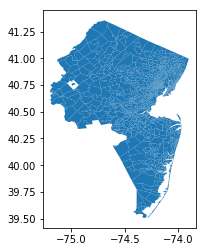

In [55]:
gdf.plot()

In [56]:
from matplotlib.colors import LinearSegmentedColormap
def plot_on_map(gdf,Y):
    gdf['Y']=float('nan') #add a column for colors to visualize
    for i in gdf.index:
        if gdf.FIRST_Mu_1[i] in Y.keys(): #if the code of the mesoregion shape has the data corresponding to it
            gdf['Y'][i]=1.0*Y[gdf.FIRST_Mu_1[i]]/max(Y.values()) #set a color corresponding to the quantity
    ax=gdf.dropna().plot(column='Y',cmap = 'cool')
    return gdf

In [52]:
#pop = NJ[['Municipality_Name', 'Pop_Change']].copy()
#pop = pop.to_dict()
#pop_keys = NJ['Municipality_Name'].copy()
#pop_values = NJ['Pop_Change'].copy()
#dictionary = dict(zip(pop_keys, pop_values))
#dictionary.keys
MN=NJ.Municipality_Name.unique(); 
PNames={r['Municipality_Name']:r['Pop_Change'] for i,r in NJ.iterrows()}
ENames={r['Municipality_Name']:r['Employ_Change'] for i,r in NJ.iterrows()}
P15Names={r['Municipality_Name']:r['Pop_2015'] for i,r in NJ.iterrows()}
PBergen={r['Municipality_Name']:r['Pop_Change'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
EBergen={r['Municipality_Name']:r['Employ_Change'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
P15Bergen={r['Municipality_Name']:r['Pop_2015'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
E15Bergen={r['Municipality_Name']:r['Employ_2015'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}
#PBergen = {}
#for p in P:
#    df=NJ[NJ.County=='Bergen']
#    PBergen[[PNames[p]]]=NJ.Pop_Change[NJ.County=='Bergen'].mean()
#NJ.County=='Bergen'{r['Municipality_Name']:r['Pop_Change'] for i,r in NJ.iterrows()}


In [ ]:
plot_on_map(gdf,gdf.FIRST_COUN);

### Forecasted Employment Growth in NJ Transit Covered Areas Statewide

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


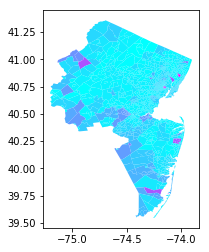

In [11]:
plot_on_map(gdf,ENames);

### Forecasted Population Growth in NJ Transit Covered Areas Statewide

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


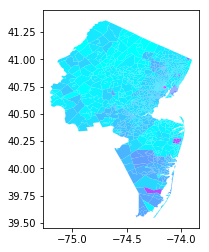

In [12]:
plot_on_map(gdf,PNames);

### 2015 Population in NJ Transit Covered Areas Statewide

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


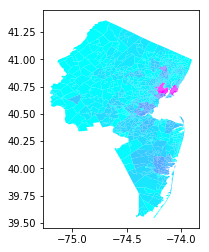

In [13]:
plot_on_map(gdf,P15Names);

### Forecasted Population Growth in Bergen County

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


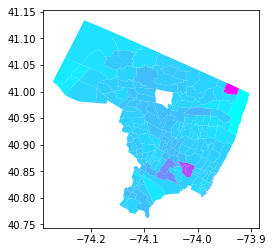

In [47]:
plot_on_map(gdf,PBergen);

### 2015 Population in Bergen County

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


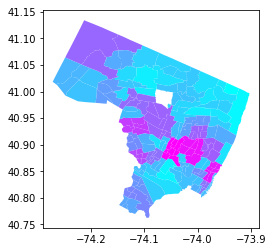

In [48]:
plot_on_map(gdf,P15Bergen);

### Projected Employment Growth in Bergen County

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


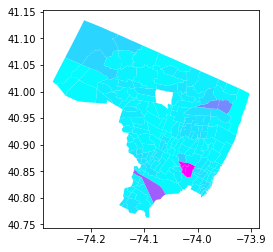

In [31]:
plot_on_map(gdf,EBergen);

### 2015 Employment in Bergen County

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


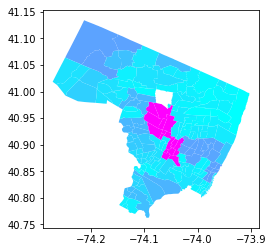

In [32]:
plot_on_map(gdf,E15Bergen);

### Clustering

After looking at the data, we've decided to cluster the municipalities.  

In [92]:
NJ_subset = NJ[['Pop_2015', 'Pop_Change', 'Employ_2015', 'Employ_Change']]


In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

X = NJ_subset.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.18762199, -0.35682506, -0.50169703],
       [-1.22700229, -0.52871063, -0.94284479],
       [-0.29226712, -0.27240873, -0.03080099],
       ...,
       [-0.87246043, -0.46680059, -0.64439247],
       [ 0.18812149, -0.49768461,  1.08589533],
       [-1.22700229, -0.5581747 , -0.94284479]])

In [94]:
num_clusters = 4

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

print(labels)

[0 0 0 0 3 0 0 0 0 0 3 0 3 0 3 3 3 0 3 0 0 0 1 0 0 0 0 0 0 0 0 3 3 0 0 3 0
 0 0 0 0 0 0 0 0 1 0 3 0 0 3 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 0 3 3 0 0 0
 3 0 3 0 3 3 0 3 3 2 0 3 3 0 0 3 3 3 0 0 0 3 2 3 3 1 3 0 3 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 3 1 3 3 3 1 3 3
 0 3 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 3 3 0 0 0 0 0 0 3 3 0 3
 0 3 0 0 3 0 3 0 3 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 3 0 3 3 3 0 0 0
 0 0 3 0 0 0 3 3 0 3 0 0 3 0 1 0 3 0 0 3 3 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0 1 0 0 0 0 3 1 0 0 0 3 0 1 0 0 3 3
 0 0 3 1 0 1 0 3 0 0 3 0 0 3 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 1 0 0 0 3 3 0 3 3 3 0 0 0 3 3 1 3 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [95]:
NJ_New = NJ
NJ_New["Labels"] = labels
NJ_New.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
0,Bergen,3.400301e+09,Allendale borough,6674.0,7335.0,0.099041,2262.0,2483.0,0.097701,2836.0,3064.0,0.080395,0
1,Bergen,3.400301e+09,Alpine borough,1849.0,1849.0,0.000000,611.0,611.0,0.000000,415.0,415.0,0.000000,0
2,Bergen,3.400305e+09,Bergenfield borough,27181.0,29602.0,0.089070,8890.0,9682.0,0.089089,4025.0,4694.0,0.166211,0
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256,0
4,Bergen,3.400310e+09,Carlstadt borough,6224.0,6833.0,0.097847,2384.0,2607.0,0.093540,12855.0,13455.0,0.046674,3


In [96]:
NJ_New.groupby('Labels').mean()

,Municipality_Code,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change
Labels,,,,,,,,,,
0,3.402404e+09,8069.764706,9078.900735,0.111085,3046.830882,3519.838235,0.149168,2561.286765,2978.628676,0.185435
1,3.402642e+09,72496.176471,86486.647059,0.177015,24415.470588,29655.764706,0.202702,43784.470588,48600.000000,0.111212
2,3.401544e+09,271218.500000,349095.000000,0.292218,99804.500000,137179.500000,0.370608,144020.500000,170936.000000,0.191189
3,3.402238e+09,30000.288889,33825.866667,0.120603,11056.511111,12758.644444,0.149367,14157.611111,16184.600000,0.145679


Looking at the Clusters we see the Eastern side of the state is somehow distinct from the West.  

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


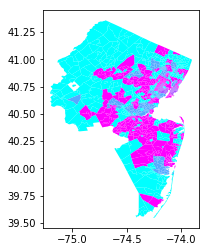

In [80]:
Cluster_Names={r['Municipality_Name']:r['Labels'] for i,r in NJ.iterrows()}
plot_on_map(gdf,Cluster_Names);

In [97]:
Bergen_Cluster={r['Municipality_Name']:r['Labels'] for i,r in NJ[NJ.County=='Bergen'].iterrows()}

Looking at Bergen County Specifically, we see of a pattern in the clusters. We do see, however, that hte only a few areas are part of cluster one and there are no cluster 2s in the region.  The areas in cluster one seem distinctive due to their employment size as cluster 3 has municipalities with similar populations.  

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


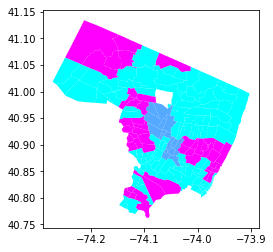

In [98]:
plot_on_map(gdf, Bergen_Cluster);

In [107]:
NJ_New[(NJ_New.County =='Bergen')&(NJ_New.Labels == 0)]

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
0,Bergen,3.400301e+09,Allendale borough,6674.0,7335.0,0.099041,2262.0,2483.0,0.097701,2836.0,3064.0,0.080395,0
1,Bergen,3.400301e+09,Alpine borough,1849.0,1849.0,0.000000,611.0,611.0,0.000000,415.0,415.0,0.000000,0
2,Bergen,3.400305e+09,Bergenfield borough,27181.0,29602.0,0.089070,8890.0,9682.0,0.089089,4025.0,4694.0,0.166211,0
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256,0
5,Bergen,3.400314e+09,Cliffside Park borough,23891.0,25675.0,0.074672,9955.0,10685.0,0.073330,2804.0,3323.0,0.185093,0
6,Bergen,3.400314e+09,Closter borough,8533.0,9040.0,0.059416,2762.0,2943.0,0.065532,3020.0,5249.0,0.738079,0
7,Bergen,3.400316e+09,Cresskill borough,8795.0,9449.0,0.074360,3037.0,3258.0,0.072769,3182.0,3396.0,0.067253,0
8,Bergen,3.400318e+09,Demarest borough,4981.0,5497.0,0.103594,1608.0,1771.0,0.101368,896.0,1037.0,0.157366,0
9,Bergen,3.400318e+09,Dumont borough,17736.0,19148.0,0.079612,6379.0,6875.0,0.077755,2089.0,2462.0,0.178554,0
11,Bergen,3.400320e+09,Edgewater borough,11944.0,13740.0,0.150368,5753.0,6577.0,0.143230,4862.0,5648.0,0.161662,0


In [108]:
NJ_New[(NJ_New.County =='Bergen')&(NJ_New.Labels == 1)]

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
22,Bergen,3.400329e+09,Hackensack city,43768.0,50013.0,0.142684,18222.0,21288.0,0.168258,42488.0,45032.0,0.059876,1
45,Bergen,3.400356e+09,Paramus borough,26956.0,30664.0,0.137558,8710.0,10047.0,0.153502,42332.0,44441.0,0.049820,1


In [109]:
NJ_New[(NJ_New.County =='Bergen')&(NJ_New.Labels == 2)]

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels


In [110]:
NJ_New[(NJ_New.County =='Bergen')&(NJ_New.Labels == 3)]

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
4,Bergen,3.400310e+09,Carlstadt borough,6224.0,6833.0,0.097847,2384.0,2607.0,0.093540,12855.0,13455.0,0.046674,3
10,Bergen,3.400320e+09,East Rutherford borough,9105.0,9626.0,0.057221,3822.0,4065.0,0.063579,11991.0,24173.0,1.015929,3
12,Bergen,3.400321e+09,Elmwood Park borough,19820.0,22087.0,0.114379,7085.0,7879.0,0.112068,8985.0,9823.0,0.093267,3
14,Bergen,3.400321e+09,Englewood city,27753.0,30631.0,0.103701,10142.0,11246.0,0.108854,15193.0,16218.0,0.067465,3
15,Bergen,3.400322e+09,Englewood Cliffs borough,5366.0,5883.0,0.096347,1830.0,2000.0,0.092896,9065.0,9576.0,0.056371,3
16,Bergen,3.400322e+09,Fair Lawn borough,33524.0,36933.0,0.101688,12115.0,13424.0,0.108048,12344.0,13447.0,0.089355,3
18,Bergen,3.400324e+09,Fort Lee borough,39521.0,43747.0,0.106930,17752.0,20099.0,0.132210,15545.0,16820.0,0.082020,3
31,Bergen,3.400342e+09,Lyndhurst township,21039.0,23989.0,0.140216,8415.0,9756.0,0.159358,11080.0,12004.0,0.083394,3
32,Bergen,3.400343e+09,Mahwah township,26358.0,28193.0,0.069618,9547.0,10320.0,0.080968,15587.0,19698.0,0.263745,3
35,Bergen,3.400348e+09,Montvale borough,8067.0,8896.0,0.102764,2816.0,3099.0,0.100497,11055.0,11543.0,0.044143,3


### Top 5 Municipalities for Bergen County Population Growth Projections

In [99]:
#clust = NJ[County=='Bergen'].groupby(['County','Municipality_Name'], as_index=False)['Pop_Change'].sum()
PopDF = NJ[(NJ.County=='Bergen')].sort_values(['Pop_Change'], ascending=[False]).groupby('Municipality_Name').head(5)
PopDF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
54,Bergen,3.400364e+09,Rockleigh borough,548.0,856.0,0.562044,76.0,138.0,0.815789,1622.0,1716.0,0.057953,0
49,Bergen,3.400363e+09,Ridgefield Park village,12946.0,17960.0,0.387301,4869.0,7714.0,0.584309,3919.0,10210.0,1.605256,0
58,Bergen,3.400369e+09,South Hackensack township,2493.0,3120.0,0.251504,869.0,1143.0,0.315305,6346.0,6691.0,0.054365,0
36,Bergen,3.400348e+09,Moonachie borough,2776.0,3247.0,0.169669,1016.0,1183.0,0.164370,5614.0,5903.0,0.051478,0
68,Bergen,3.400383e+09,Wood-Ridge borough,9339.0,10884.0,0.165435,3459.0,4630.0,0.338537,1919.0,2241.0,0.167796,0


### Top 5 Municipalities for Bergen County Employment Growth Projections

In [100]:
EmployDF = NJ[(NJ.County=='Bergen')].sort_values(['Employ_Change'], ascending=[False]).groupby('Municipality_Name').head(5)
EmployDF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
49,Bergen,3.400363e+09,Ridgefield Park village,12946.0,17960.0,0.387301,4869.0,7714.0,0.584309,3919.0,10210.0,1.605256,0
10,Bergen,3.400320e+09,East Rutherford borough,9105.0,9626.0,0.057221,3822.0,4065.0,0.063579,11991.0,24173.0,1.015929,3
6,Bergen,3.400314e+09,Closter borough,8533.0,9040.0,0.059416,2762.0,2943.0,0.065532,3020.0,5249.0,0.738079,0
3,Bergen,3.400306e+09,Bogota borough,8284.0,9397.0,0.134355,2773.0,3136.0,0.130905,1015.0,1336.0,0.316256,0
32,Bergen,3.400343e+09,Mahwah township,26358.0,28193.0,0.069618,9547.0,10320.0,0.080968,15587.0,19698.0,0.263745,3


### Top 5 Municipalities for Bergen County 2015 Population

In [101]:
Pop15DF = NJ[(NJ.County=='Bergen')].sort_values(['Pop_2015'], ascending=[False]).groupby('Municipality_Name').head(5)
Pop15DF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
22,Bergen,3.400329e+09,Hackensack city,43768.0,50013.0,0.142684,18222.0,21288.0,0.168258,42488.0,45032.0,0.059876,1
59,Bergen,3.400372e+09,Teaneck township,40492.0,44834.0,0.107231,13533.0,15313.0,0.131530,15533.0,16741.0,0.077770,3
18,Bergen,3.400324e+09,Fort Lee borough,39521.0,43747.0,0.106930,17752.0,20099.0,0.132210,15545.0,16820.0,0.082020,3
16,Bergen,3.400322e+09,Fair Lawn borough,33524.0,36933.0,0.101688,12115.0,13424.0,0.108048,12344.0,13447.0,0.089355,3
20,Bergen,3.400326e+09,Garfield city,31258.0,34888.0,0.116130,11206.0,12641.0,0.128056,5942.0,6943.0,0.168462,0


### Top 5 Municipalities for Bergen County 2015 Employment

In [87]:
Employ15DF = NJ[(NJ.County=='Bergen')].sort_values(['Employ_2015'], ascending=[False]).groupby('Municipality_Name').head(5)
Employ15DF.head(5)

,County,Municipality_Code,Municipality_Name,Pop_2015,Pop_2045,Pop_Change,House_2015,House_2045,House_Change,Employ_2015,Employ_2045,Employ_Change,Labels
22,Bergen,3.400329e+09,Hackensack city,43768.0,50013.0,0.142684,18222.0,21288.0,0.168258,42488.0,45032.0,0.059876,1
45,Bergen,3.400356e+09,Paramus borough,26956.0,30664.0,0.137558,8710.0,10047.0,0.153502,42332.0,44441.0,0.049820,1
32,Bergen,3.400343e+09,Mahwah township,26358.0,28193.0,0.069618,9547.0,10320.0,0.080968,15587.0,19698.0,0.263745,3
18,Bergen,3.400324e+09,Fort Lee borough,39521.0,43747.0,0.106930,17752.0,20099.0,0.132210,15545.0,16820.0,0.082020,3
59,Bergen,3.400372e+09,Teaneck township,40492.0,44834.0,0.107231,13533.0,15313.0,0.131530,15533.0,16741.0,0.077770,3


In terms of absolute size, Hackensack is clearly the largest municipality for both population and employment, but is not in the top 5 for projected growth.  Ridgefield park is about half the size of Hackensack, but is projected to see large amounts of growth in both population and employment.  Narrowing it down to two municipalities, we'll take a deeper look into the 

In [9]:
Hackensack_address = 'Essex Street Station, Hackensack, NJ 07601'
Ridgefield_Park_address = '1 Station Plaza, Ridgefield Park, NJ 07660'

geolocator = Nominatim()
H_location = geolocator.geocode(Hackensack_address)
H_latitude = H_location.latitude
H_longitude = H_location.longitude
print(H_latitude, H_longitude)
geolocator = Nominatim()
R_location = geolocator.geocode(Ridgefield_Park_address)
R_latitude = R_location.latitude
R_longitude = R_location.longitude
print(R_latitude, R_longitude)

/srv/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


40.8783508 -74.0471659
40.8570442 -74.0215285


In [10]:
radius = 500
LIMIT = 100

# create URL
H_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    H_latitude, 
    H_longitude, 
    radius, 
    LIMIT)

R_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    R_latitude, 
    R_longitude, 
    radius, 
    LIMIT)

print(H_url)
print(R_url)

https://api.foursquare.com/v2/venues/explore?&client_id=YNANXRBNSXSLZ1FP41ZXOTBYEB2PDCEVYJYGQWG4ADKL0JGI&client_secret=ZC4GQC2QHK123SPM3T0Q2WPOYMLV3DL4GHGT3BTLFOHEHXHQ&v=20180604&ll=40.8783508,-74.0471659&radius=500&limit=100
https://api.foursquare.com/v2/venues/explore?&client_id=YNANXRBNSXSLZ1FP41ZXOTBYEB2PDCEVYJYGQWG4ADKL0JGI&client_secret=ZC4GQC2QHK123SPM3T0Q2WPOYMLV3DL4GHGT3BTLFOHEHXHQ&v=20180604&ll=40.8570442,-74.0215285&radius=500&limit=100


In [11]:
H_results = requests.get(H_url).json()
H_results

{'meta': {'code': 200, 'requestId': '5be04a0b9fb6b71cc5d31899'},
 'response': {'headerLocation': 'Hackensack',
  'headerFullLocation': 'Hackensack',
  'headerLocationGranularity': 'city',
  'totalResults': 11,
  'suggestedBounds': {'ne': {'lat': 40.8828508045, 'lng': -74.04122541901678},
   'sw': {'lat': 40.8738507955, 'lng': -74.05310638098321}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b919aa9f964a52031c933e3',
       'name': 'Pizza Hut',
       'location': {'address': '53-55 Essex St',
        'lat': 40.87793624504493,
        'lng': -74.04720492666456,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.87793624504493,
          'lng': -74.04720492666456}],
        'distance': 46,
        'postalCode': '07601',
        'cc': 'US',
        'cit

In [12]:
R_results = requests.get(R_url).json()
R_results

{'meta': {'code': 200, 'requestId': '5be04a121ed219724085e951'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Ridgefield Park',
  'headerFullLocation': 'Ridgefield Park',
  'headerLocationGranularity': 'city',
  'totalResults': 17,
  'suggestedBounds': {'ne': {'lat': 40.8615442045, 'lng': -74.015589930103},
   'sw': {'lat': 40.852544195499995, 'lng': -74.027467069897}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bc0bc33b492d13a07c3a460',
       'name': "Palermo's Bakery",
       'location': {'address': '187 Main St',
        'lat': 40.856403113216224,
        'lng': -74.02520799080945,
        'labeledLatLngs': [{'label': 'display',


In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
H_venues = H_results['response']['groups'][0]['items']
    
H_nearby_venues = json_normalize(H_venues) # flatten JSON

# filter columns
H_filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
H_nearby_venues =H_nearby_venues.loc[:, H_filtered_columns]

# filter the category for each row
H_nearby_venues['venue.categories'] = H_nearby_venues.apply(get_category_type, axis=1)

# clean columns
H_nearby_venues.columns = [col.split(".")[-1] for col in H_nearby_venues.columns]

H_nearby_venues.head()

,name,categories,lat,lng
0,Pizza Hut,Pizza Place,40.877936,-74.047205
1,Choripan Rodizio Too,Argentinian Restaurant,40.879572,-74.044739
2,Mi Rancho,Mexican Restaurant,40.880023,-74.044135
3,Greek Island Grill,Greek Restaurant,40.880524,-74.043965
4,Pollos Mario,Latin American Restaurant,40.880207,-74.044143


In [15]:
R_venues = R_results['response']['groups'][0]['items']
    
R_nearby_venues = json_normalize(R_venues) # flatten JSON

# filter columns
R_filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
R_nearby_venues =R_nearby_venues.loc[:, R_filtered_columns]

# filter the category for each row
R_nearby_venues['venue.categories'] = R_nearby_venues.apply(get_category_type, axis=1)

# clean columns
R_nearby_venues.columns = [col.split(".")[-1] for col in R_nearby_venues.columns]

R_nearby_venues.head()

,name,categories,lat,lng
0,Palermo's Bakery,Bakery,40.856403,-74.025208
1,MK Valencia,Italian Restaurant,40.857814,-74.024938
2,Sparta Taverna,Restaurant,40.856988,-74.025325
3,CVS/pharmacy,Pharmacy,40.856595,-74.025282
4,Java Day,Bagel Shop,40.857617,-74.024980


In [16]:
R_nearby_venues.categories.unique()

array(['Bakery', 'Italian Restaurant', 'Restaurant', 'Pharmacy',
       'Bagel Shop', 'Japanese Restaurant', 'Liquor Store', 'Donut Shop',
       'Pizza Place', 'Bank', 'Convenience Store', 'Grocery Store',
       'Fast Food Restaurant', 'Sandwich Place', 'Chinese Restaurant',
       'Deli / Bodega'], dtype=object)

In [17]:
H_nearby_venues.categories.unique()

array(['Pizza Place', 'Argentinian Restaurant', 'Mexican Restaurant',
       'Greek Restaurant', 'Latin American Restaurant',
       'Italian Restaurant', 'Fast Food Restaurant', 'Theater',
       'Pharmacy', 'Indian Restaurant', 'Gym'], dtype=object)

## Conclusion!

After assessing all of the factors, Hackensack represents the best business opportunity.  This is because it is distinctive both in population and employment size.  Additionally, it does not currently have any Deli/Bodega, Bakery, Bagel Shop, or Donut Shop in the vicinity of the train station, meaning this market is open for new businesses.